# Stacked Autoencoders

Let's use MNIST:

## Importing the Modules
Let us begin by importing the modules.

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import sklearn


# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)



In [ ]:
type(sklearn)

module

## Preparing the Dataset

- Let us load the fashion mnist dataset from Keras data sets.

- We shall then split the data into train, validation, and test parts.

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full/ 255.
X_test = X_test/ 255.
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

## Defining some Utility Functions

- We shall define 3 utility functions which we will be using further:

 - `rounded_accuracy`: we define this function to get the rounded accuracy by calculating the accuracies using the rounded values of the predicted value and the actual value.

 - `plot_image` : used to plot the given image

 - `show_reconstructions` : we shall use this function to show how our trained model is able to reconstruct the validation data.



**Note:**

- `keras.metrics.binary_accuracy` : calculates how often predictions matches binary labels. It computes the mean accuracy rate across all predictions for binary classification problems.

- `plt.imshow` : Display data as an image

- `plt.axis("off")` : It does not display the axis.

- `plt.subplot` : Add a subplot to the current figure.

In [ ]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [ ]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])


## Building the Autoencoder

Let's build a stacked Autoencoder with 3 hidden layers and 1 output layer (i.e., 2 stacked Autoencoders).



In [ ]:
tf.random.set_seed(42)
np.random.seed(42)


stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu"),
])
stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss="binary_crossentropy",
                   optimizer=keras.optimizers.SGD(lr=1.5), metrics=[rounded_accuracy])

import time
start = time.time()

history = stacked_ae.fit(X_train, X_train, epochs=20,
                         validation_data=(X_valid, X_valid))

end = time.time()
print("Time of execution:", round(end-start,2),"seconds")

Epoch 1/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3381 - rounded_accuracy: 0.8870 - val_loss: 0.3171 - val_rounded_accuracy: 0.8992
Epoch 2/20
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3056 - rounded_accuracy: 0.9152 - val_loss: 0.3021 - val_rounded_accuracy: 0.9197
Epoch 3/20
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2986 - rounded_accuracy: 0.9215 - val_loss: 0.2984 - val_rounded_accuracy: 0.9202
Epoch 4/20
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2948 - rounded_accuracy: 0.9249 - val_loss: 0.2938 - val_rounded_accuracy: 0.9285
Epoch 5/20
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2923 - rounded_accuracy: 0.9272 - val_loss: 0.2919 - val_rounded_accuracy: 0.9284
Epoch 6/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2904 - rounded_accuracy: 0.9289 - val_loss: 0.2914 - val_rounded_accuracy: 0.9306
Epoch 7/20
1719/1719 [==================

## Evaluating the Model Performance

- Let us now view how well our autoencoder is trained and how good the reconstructed images are trained.

- Use show_reconstructions function and pass stacked_ae and X_test as input argument. This displays 5 ground truth images and the corresponding reconstructed images.

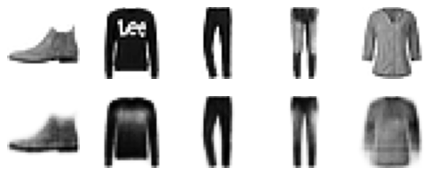

In [ ]:
show_reconstructions(stacked_ae, X_test)

- Let us view the class-wise clusters for the validation data as predicted by our model `stacked_ae`. Since we can't display multiple-dimensions, we shall do this by using `TSNE` dimensionality reduction.

 - We shall use `predict` of `stacked_encoder` on `X_valid` to get the compressed data of the validation data.

 - Use `fit_transform` of `TSNE()` to get the 2D representation of the compressed validation data and scale it data.

 - Now plot this data with colormaps for each class.

 Use the following code to do get the 2D representation of the compressed validation data.

In [ ]:
np.random.seed(42)

from sklearn.manifold import TSNE

start = time.time()

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())

end = time.time()

print("Time of execution:", round(end-start,2),"seconds")

Time of execution: 39.23 seconds


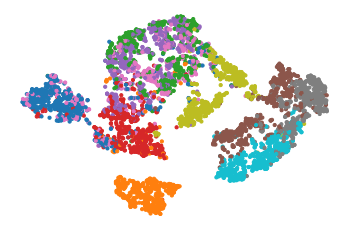

In [ ]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.axis("off")
plt.show()

Time of execution: 84.18 seconds


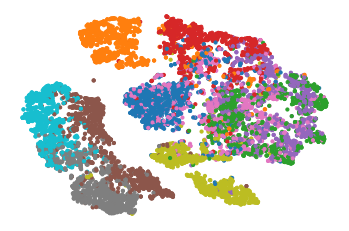

In [ ]:
np.random.seed(42)

from sklearn.manifold import TSNE

start = time.time()

X_test_compressed = stacked_encoder.predict(X_test)
tsne = TSNE()
X_test_2D = tsne.fit_transform(X_test_compressed)
X_test_2D = (X_test_2D - X_test_2D.min()) / (X_test_2D.max() - X_test_2D.min())

end = time.time()

print("Time of execution:", round(end-start,2),"seconds")

plt.scatter(X_test_2D[:, 0], X_test_2D[:, 1], c=y_test, s=10, cmap="tab10")
plt.axis("off")
plt.show()

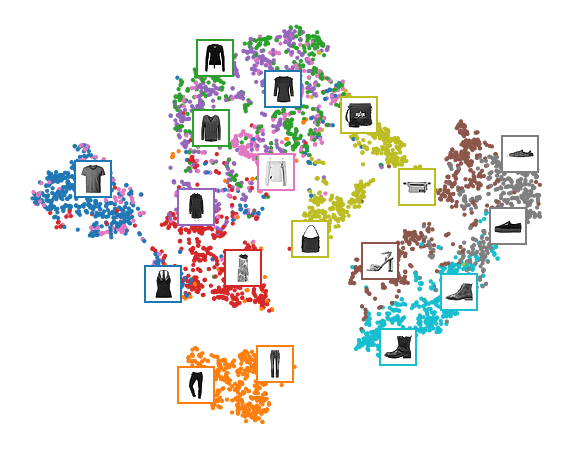

In [ ]:
# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

In [ ]:
stacked_ae.evaluate(X_test, X_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.2843 - rounded_accuracy: 0.9366


[0.2843400835990906, 0.9366289973258972]

In [ ]:
stacked_ae.evaluate(X_train, X_train)

1719/1719 [==============================] - 3s 2ms/step - loss: 0.2817 - rounded_accuracy: 0.9379


[0.28172656893730164, 0.9378564953804016]

In [ ]:
stacked_ae.evaluate(X_valid, X_valid)

157/157 [==============================] - 0s 2ms/step - loss: 0.2839 - rounded_accuracy: 0.9368


[0.2839103937149048, 0.9368303418159485]